In [2]:
import sys
sys.path.append('../../')

In [3]:
preprocessed_dataset_path = 'preprocessed_dataset/'

In [4]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation, data_preprocessing_high_dimension
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re

Here, the volumetric dataset is preprocessed to group the same brain regions.\
Then mass univariate test is preformed, across multiple regions.

# Main analysis

In [6]:
european_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/european_volumetric_df.csv')
# mixed_volumetric_dataset_term = pd.read_csv(
#     preprocessed_dataset_path +
#     'imaging_data/volumetric/term/mixed_volumetric_df.csv')

In [7]:
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]
df = european_volumetric_dataset_term.copy()
df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping=None)
df = data_exploration.MassUnivariate.remove_outliers(df,
                                                    col=dependentVar,
                                                     threshold=3,
                                                    remove_schemes='percentage',
                                                    percentage_of_outlier=0.1)
df = df.rename(columns = {'AAL 93':'AAL 109'})
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]

In [8]:
# imputed_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_ASD_AllLDimputed')

PRS_ASD_EuroLD=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_Euro_LD')
PRS_SCZ_EuroLD = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_eur_ld_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_SCZ_Euro_LD')
# PRS_ASD_EuroLD_imputed=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_EuroLDimputed')

df = df.rename(columns={i:i+'_ASD_All_LD' for i in df.columns if 'PRS' in i})

# df = df.merge(imputed_PRS,left_on='ID',right_on=imputed_PRS.index)
df = df.merge(PRS_ASD_EuroLD,left_on='ID',right_on=PRS_ASD_EuroLD.index)
# df = df.merge(PRS_SCZ_EuroLD,left_on='ID',right_on=PRS_SCZ_EuroLD.index)


# df = df.merge(PRS_ASD_EuroLD_imputed,left_on='ID',right_on=PRS_ASD_EuroLD_imputed.index)

In [176]:
df.shape

(205, 4553)

In [9]:
# # plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['patch.edgecolor'] = 'none'
# plt.rcParams["axes.grid.axis"] ="y"
# sns.set_style('whitegrid')
# g = sns.FacetGrid(mixed_volumetric_dataset_term[['GA_vol','PMA_vol','cohort']],col='cohort',height = 4)
# g.map(sns.histplot,'GA_vol',label='GA at birth',color='darkblue',alpha=0.15,shrink=.8)
# g.map(sns.histplot,'PMA_vol',label='PMA at scan',color='darkblue',alpha=0.5,shrink=.8)
# g.set_ylabels('Number of subjects',fontsize=15)
# g.set_xlabels('[weeks]',fontsize=15,fontname='Helvetica')
# g.axes[0][0].set_yticklabels(([int(i) for i in g.axes[0][0].get_yticks()]),size=15)
# g.axes[0][0].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)
# g.axes[0][1].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)


# g.axes[0][0].set_title('cohort = European',size=15)
# g.axes[0][1].set_title('cohort = Asian',size=15)
# plt.legend(ncol=2,loc='upper center',fontsize=15,frameon=False)
# sns.despine(bottom=True,left=True)
# # g.savefig(f'./{preprocessed_dataset_path}/output_plot/Cohort_age_distribution.pdf',transparent=True)

## AAL atlas

In [13]:
combined = df[[
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('AAL \d', i))
]].copy()
# combined = df[[i for i in df
#                .columns if ('EuroLD' in i)]]
correlation_matrix = np.corrcoef(combined, rowvar=False)
_ = data_exploration.matSpDLite(correlation_matrix, alpha=0.05)

Effective Number of Independent Variables [Veff] is 47.175858187992
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 28.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0017857142857142872


In [200]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('AAL \d',i))]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','17 ICV (all except bone)']+ancestry,
    dependentVar_cols=dependentVar_cols)

100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.05it/s]


In [31]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if 'Euro' in i]
european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval').head(22)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
1135,AAL 20,0.002635,0.960764,-0.055965,0.260123,0.061474,3.998939e-01,0.812604,4.373374e-29,0.005433,0.888206,-0.066348,0.082100,-0.008314,0.824302,0.152844,0.000083,-0.005568,0.945826,PRS_1e-07_ASD_Euro_LD
1551,AAL 64,-0.009784,0.872176,0.027196,0.628984,0.094621,2.501698e-01,0.706296,5.886457e-20,-0.063131,0.149204,-0.015154,0.726218,0.114031,0.007550,-0.154017,0.000421,0.020678,0.824477,PRS_0.001_ASD_Euro_LD
1738,AAL 65,0.063767,0.275811,0.073011,0.178490,0.049028,5.343836e-01,0.751252,3.639813e-23,-0.016115,0.701688,-0.008690,0.834198,0.009559,0.813735,-0.137780,0.000999,-0.134765,0.133587,PRS_0.05_ASD_Euro_LD
1956,AAL 4,0.014010,0.762159,-0.020655,0.629851,-0.010183,8.707356e-01,0.883438,9.171722e-40,0.040681,0.227042,-0.066034,0.046181,-0.030197,0.348575,0.107343,0.001282,-0.029610,0.676238,PRS_1_ASD_Euro_LD
1092,AAL 70,0.022894,0.758212,-0.045512,0.511556,0.054777,5.900580e-01,0.642028,1.736619e-12,-0.045460,0.396566,-0.090658,0.087098,-0.044030,0.397915,0.169482,0.001414,-0.048385,0.670517,PRS_1e-08_ASD_Euro_LD
1637,AAL 57,-0.112016,0.018818,-0.067652,0.124196,0.167383,9.378639e-03,0.794123,9.058344e-34,-0.020366,0.548735,0.026590,0.430475,0.060379,0.067829,-0.107891,0.001544,0.236734,0.001315,PRS_0.01_ASD_Euro_LD
1042,AAL 20,0.008623,0.873808,-0.071550,0.158359,0.059193,4.254281e-01,0.816091,1.212725e-28,-0.001302,0.973454,-0.062016,0.108767,-0.005336,0.888302,0.121401,0.001730,-0.018225,0.826245,PRS_1e-08_ASD_Euro_LD
1645,AAL 65,0.066578,0.257613,0.070135,0.198290,0.059621,4.519524e-01,0.742275,1.076051e-22,-0.011605,0.782823,-0.005113,0.902618,0.017828,0.662422,-0.130874,0.001942,-0.140706,0.119805,PRS_0.01_ASD_Euro_LD
1644,AAL 64,-0.007911,0.897483,0.019763,0.728353,0.117106,1.584858e-01,0.709284,7.510065e-20,-0.063409,0.150834,-0.014591,0.738504,0.116070,0.007071,-0.135443,0.002158,0.016720,0.859272,PRS_0.01_ASD_Euro_LD
1863,AAL 4,0.014211,0.759501,-0.021883,0.610659,-0.007254,9.079456e-01,0.881614,1.682971e-39,0.039660,0.239982,-0.064130,0.053095,-0.031405,0.331053,0.101936,0.002238,-0.030033,0.672756,PRS_0.5_ASD_Euro_LD


In [205]:
PRS_compare = european_volumetric_term_mass_univariate[(european_volumetric_term_mass_univariate['Connection']=='Dependent_Var_3')].copy()

PRS_compare['PRS_p_threshold'] = PRS_compare['threshold'].apply(lambda x: x.split('_')[1])
PRS_compare['LD'] = PRS_compare['threshold'].apply(lambda x: '_'.join(x.split('_')[2:]))
PRS_compare['-log10PRS_pval'] = -np.log10(PRS_compare['PRS_pval'])

Text(0.5, 1.0, 'Association between ASD PRS and PC4 volume in European cohort')

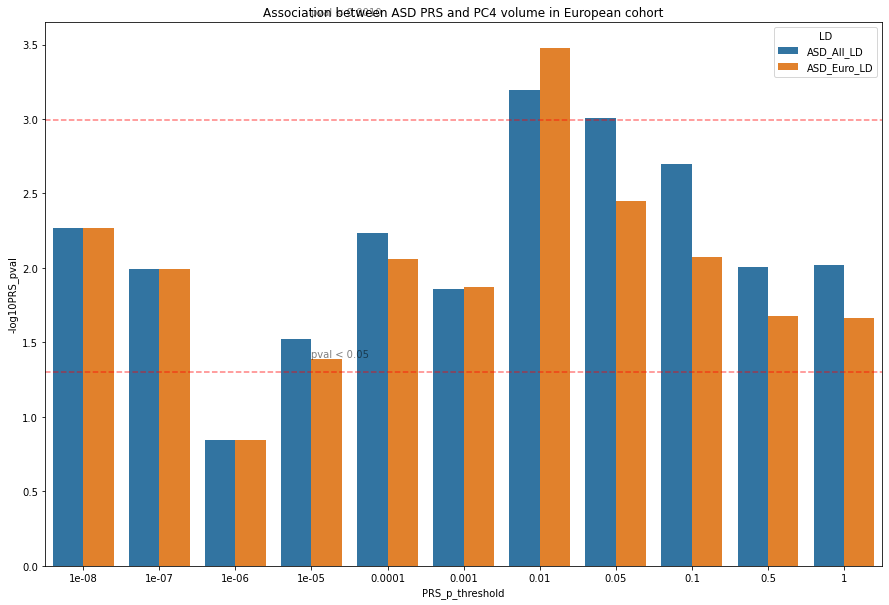

In [210]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(x='PRS_p_threshold',y='-log10PRS_pval',hue='LD',data=PRS_compare,ax=ax)
ax.axhline(-np.log10(0.05/7/7),color='red',alpha=0.5,linestyle='--')
ax.axhline(-np.log10(0.05),color='red',alpha=0.5,linestyle='--')
ax.text(3,3.7,'pval < 0.0010',alpha=0.5)
ax.text(3,1.4,'pval < 0.05',alpha=0.5)
ax.set_title('Association between ASD PRS and PC4 volume in European cohort')
# fig.savefig('../../../../../Downloads/european.png',dpi=300)

In [113]:
significant_regions = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_0.01_ASD_Euro_LD'].copy()

In [114]:
plot_values_pvals = {indx+1:-np.log10(value) for indx,value in enumerate(significant_regions['PRS_pval'])}

In [115]:
plot_values_coefs = {indx+1:value for indx,value in enumerate(significant_regions['PRS_coef'])}

In [116]:
significant_regions.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
1637,AAL 57,-0.112016,0.018818,-0.067652,0.124196,0.167383,9.378639e-03,0.794123,9.058344e-34,-0.020366,0.548735,0.026590,0.430475,0.060379,0.067829,-0.107891,0.001544,0.236734,0.001315,PRS_0.01_ASD_Euro_LD
1645,AAL 65,0.066578,0.257613,0.070135,0.198290,0.059621,4.519524e-01,0.742275,1.076051e-22,-0.011605,0.782823,-0.005113,0.902618,0.017828,0.662422,-0.130874,0.001942,-0.140706,0.119805,PRS_0.01_ASD_Euro_LD
1644,AAL 64,-0.007911,0.897483,0.019763,0.728353,0.117106,1.584858e-01,0.709284,7.510065e-20,-0.063409,0.150834,-0.014591,0.738504,0.116070,0.007071,-0.135443,0.002158,0.016720,0.859272,PRS_0.01_ASD_Euro_LD
1649,AAL 69,-0.025930,0.706705,0.020097,0.752940,-0.157365,9.161616e-02,0.828943,4.287330e-21,0.015409,0.755117,0.013500,0.783113,-0.007646,0.873205,0.146514,0.003079,0.054801,0.604642,PRS_0.01_ASD_Euro_LD
1641,AAL 61,0.059287,0.232678,-0.077152,0.094275,0.358248,2.297118e-07,0.610901,7.536316e-22,-0.015877,0.655241,-0.043441,0.219253,0.090719,0.009098,-0.100050,0.004931,-0.125297,0.101057,PRS_0.01_ASD_Euro_LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,AAL 38,0.035636,0.602344,0.069591,0.272719,-0.116789,2.063637e-01,0.794885,4.830387e-20,0.022221,0.650412,0.021774,0.654635,0.082918,0.082314,0.002584,0.957571,-0.075314,0.473502,PRS_0.01_ASD_Euro_LD
1605,AAL 25,0.002745,0.963998,0.090226,0.110515,-0.202342,1.439213e-02,0.918448,2.879988e-29,0.016455,0.705950,-0.036929,0.394043,-0.051099,0.227789,-0.002261,0.958272,-0.005802,0.950472,PRS_0.01_ASD_Euro_LD
1593,AAL 13,-0.023018,0.630184,-0.006437,0.884426,0.089090,1.680786e-01,0.822131,6.347857e-35,0.033351,0.330991,-0.044561,0.191181,-0.052462,0.115575,0.000794,0.981335,0.048647,0.507720,PRS_0.01_ASD_Euro_LD
1602,AAL 22,-0.028231,0.577921,0.173933,0.000274,-0.321322,4.842142e-06,1.037535,1.485158e-43,-0.018916,0.603048,-0.115776,0.001544,-0.011148,0.751936,-0.000703,0.984438,0.059664,0.444005,PRS_0.01_ASD_Euro_LD


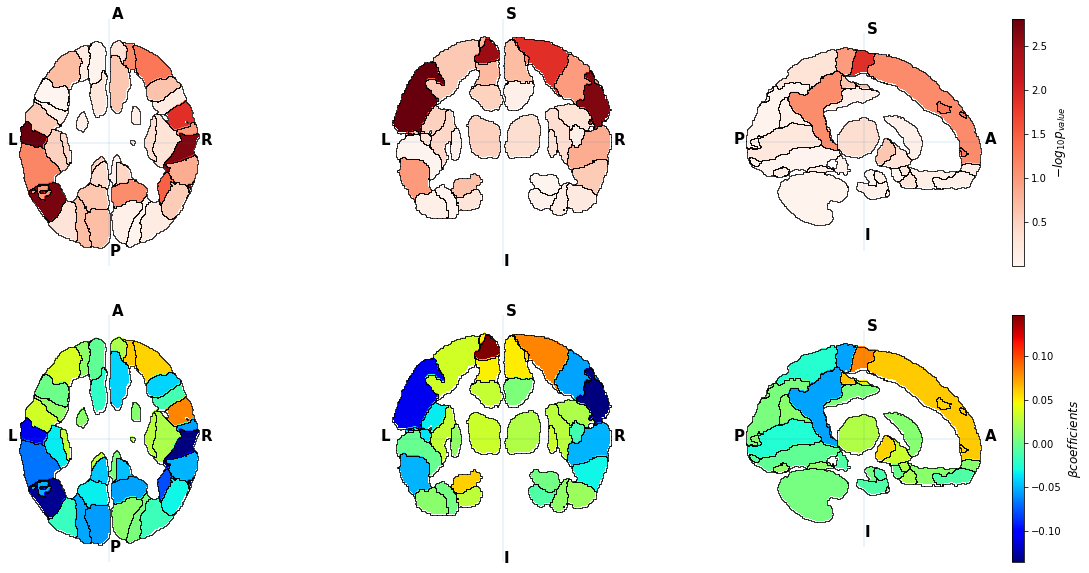

In [117]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['all'],
    atlas_slice=120,
    plot_values=plot_values_pvals,
#     plot_values_threshold=-np.log10(0.05),
    axes=axes[0, :],
    fig=fig,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    colorbar=True,
    cb_orientation='vertical',
    cb_title=r'$-log_{10}p_{value}$',
    cmap='Reds',
    cmap_reversed=False)

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['all'],
    atlas_slice=120,
    plot_values=plot_values_coefs,
#     plot_values_threshold=-np.log10(0.05),
#     mask=plot_values_coefs,
    axes=axes[1, :],
    fig=fig,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    colorbar=True,
    cb_orientation='vertical',
    cb_title=r'$\beta coefficients$',
    cmap='jet',
    cmap_reversed=False)

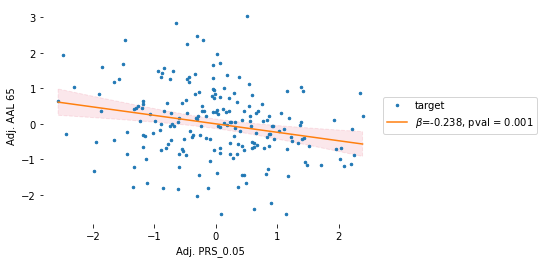

In [33]:
ylabel='AAL 65'
xlabel = 'PRS_0.05'
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)'],
    dependentVar_cols=[ylabel])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=[xlabel])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel=f'Adj. {xlabel}', ylabel=f'Adj. {ylabel}',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [201]:
# dependentVar_cols=[i for i in combined.columns if bool(re.search('Imperial \d',i))]
# dependentVar_cols = data_preprocessing.Volumes.extract_GM_Imperial(dependentVar_cols)
# df = european_volumetric_dataset_term
dependentVar_cols = [
    i for i in df.columns
    if bool(re.search('AAL \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components = .8)

Text(0, 0.5, 'Cumulative explained variance')

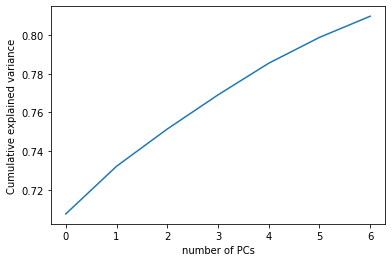

In [202]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of PCs')
plt.ylabel('Cumulative explained variance')

In [187]:
0.05/49

0.0010204081632653062

In [203]:
thresholds = [i for i in df.columns if 'PRS' in i]
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
    dependentVar_cols=X_pca)


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 13.92it/s]


In [191]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if ('Euro' in i) and ('SCZ' in i)]
european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
179,Dependent_Var_4,-0.005124,0.959799,0.029904,0.751251,-0.149720,0.278616,0.113415,0.329593,-0.002321,0.974700,0.016353,0.820935,0.084629,0.232865,-0.135959,0.057831,0.010829,0.944465,PRS_1e-05_SCZ_Euro_LD
162,Dependent_Var_1,0.168323,0.090134,-0.088156,0.337742,-0.069723,0.604157,-0.004405,0.968932,0.019689,0.782322,0.030036,0.669494,-0.149580,0.031015,0.130562,0.060894,-0.355735,0.019535,PRS_1e-07_SCZ_Euro_LD
155,Dependent_Var_1,0.170029,0.087073,-0.089470,0.330960,-0.064723,0.629999,-0.011990,0.915454,0.021339,0.764868,0.031125,0.658261,-0.153039,0.027544,0.128058,0.066154,-0.359339,0.018403,PRS_1e-08_SCZ_Euro_LD
186,Dependent_Var_4,-0.002820,0.977889,0.028880,0.759742,-0.148284,0.284219,0.111047,0.340994,-0.007146,0.922544,0.018248,0.801061,0.084675,0.233198,-0.127757,0.076765,0.005960,0.969440,PRS_0.0001_SCZ_Euro_LD
172,Dependent_Var_4,-0.002300,0.981981,0.029050,0.758649,-0.152037,0.272349,0.115141,0.323445,-0.000397,0.995677,0.013885,0.847845,0.080917,0.254801,-0.118223,0.098579,0.004862,0.975093,PRS_1e-06_SCZ_Euro_LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,Dependent_Var_4,0.001326,0.989724,0.022170,0.815747,-0.166587,0.236266,0.127201,0.286647,0.004364,0.953503,0.009257,0.898853,0.082222,0.257640,-0.007792,0.916906,-0.002802,0.985842,PRS_0.5_SCZ_Euro_LD
216,Dependent_Var_6,-0.000755,0.994101,0.144450,0.128073,0.016822,0.903924,-0.055132,0.640829,0.068328,0.359359,-0.051058,0.481203,-0.013584,0.851542,-0.007427,0.920494,0.001596,0.991854,PRS_0.1_SCZ_Euro_LD
228,Dependent_Var_4,0.001127,0.991264,0.022204,0.815482,-0.166999,0.235090,0.127681,0.284643,0.004652,0.950406,0.009260,0.898830,0.081997,0.259252,-0.006306,0.932656,-0.002382,0.987962,PRS_1_SCZ_Euro_LD
156,Dependent_Var_2,-0.037094,0.709930,-0.226765,0.015060,0.450578,0.001020,-0.226517,0.047558,-0.015361,0.830722,-0.072184,0.308975,0.030300,0.662984,0.002937,0.966477,0.078395,0.607176,PRS_1e-08_SCZ_Euro_LD


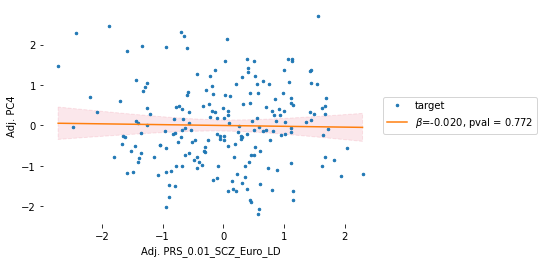

In [192]:
# PC4 was associated with the PRS 0.01 and 0.05
xlabel = 'PRS_0.01_SCZ_Euro_LD'
ylabel = 'PC4'
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)'],
    dependentVar_cols=X_pca[:,3].reshape(-1,1))
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=[xlabel])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel=f'Adj. {xlabel}', ylabel=f'Adj. {ylabel}',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [56]:
data_exploration.MassUnivariate.get_model_summary(df,
                                                 cat_independentVar_cols=['Gender'],
                                                  cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)','PRS_0.01_ASD_Euro_LD']+ancestry,
                                                  dependentVar_cols=X_pca[:,3].reshape(-1,1))

,beta_coefs,pvalues,Rsquared
const,0.023571,7.942173e-01,0.000262
PMA_vol,-0.616736,9.352137e-07,0.098641
GA_vol,0.029941,7.206704e-01,0.000493
17 ICV (all except bone),0.400239,1.276253e-04,0.058729
PRS_0.01_ASD_Euro_LD,0.234098,3.346392e-04,0.051242
euro_Anc_PC1,0.032685,6.140040e-01,0.000981
euro_Anc_PC2,-0.071534,2.667620e-01,0.004767
euro_Anc_PC3,-0.060953,3.325570e-01,0.003627
Gender_2.0,-0.049815,7.196534e-01,0.000497


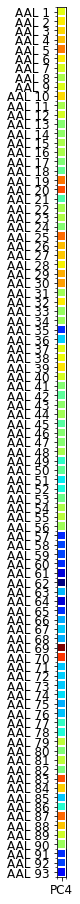

In [43]:
#see the loading matrix of PC4
fig,ax = plt.subplots(1,1,figsize=(20,16))
visualisation.visualise_heatmap(loading_matrix.loc[:,3:3],ax,xlabel=['PC4'],ylabel=loading_matrix.index.tolist())

In [57]:
plot_labels = [int(i.replace('AAL ','')) for i in loading_matrix.index]
plot_value_values = loading_matrix[3].values
plot_values = dict(zip(plot_labels,plot_value_values)) 

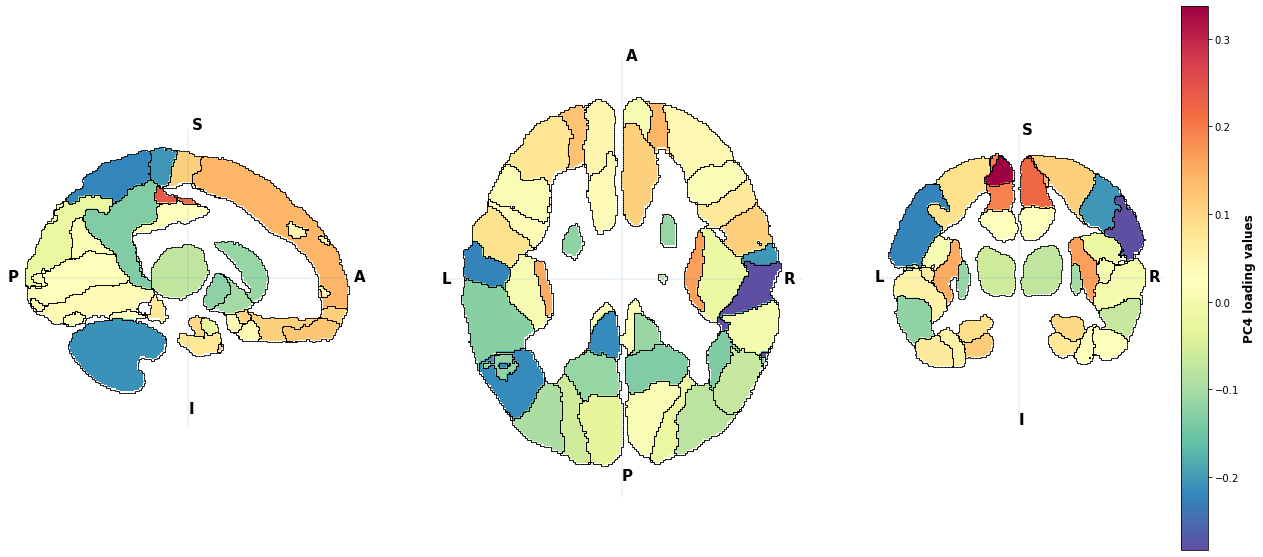

In [59]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],atlas_slice=120,plot_values=plot_values,colorbar=True,atlas_file = '../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',cb_orientation='vertical',cmap_reversed=True,cb_title = 'PC4 loading values')

In [60]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

In [81]:
new_variable = []
for variable in dependentVar_cols:
    model,_ = data_exploration.MassUnivariate.mass_univariate(df,
                                                             cat_independentVar_cols=['Gender'],
                                                             cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)']+ancestry,
                                                             dependentVar_cols=[variable])
    new_variable.append(model.resid.mean())

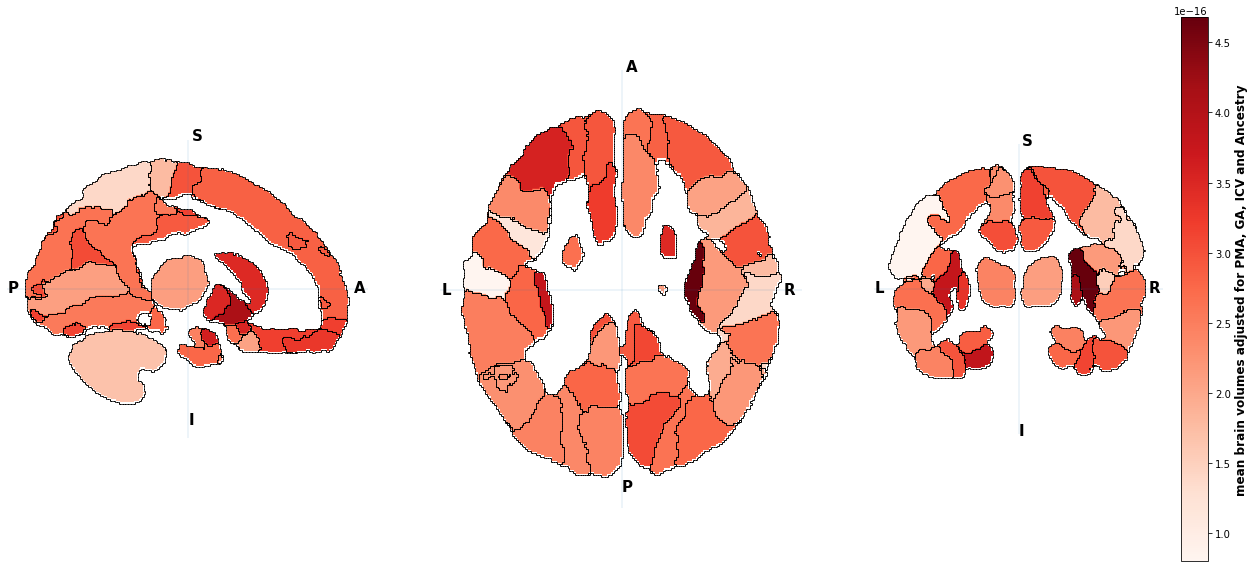

In [84]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],plot_values=dict(zip(plot_labels,new_variable)),atlas_slice=120,colorbar=True,atlas_file = '../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',cb_orientation='vertical',cmap='Reds',cmap_reversed=False,cb_title = 'mean brain volumes adjusted for PMA, GA, ICV and Ancestry')

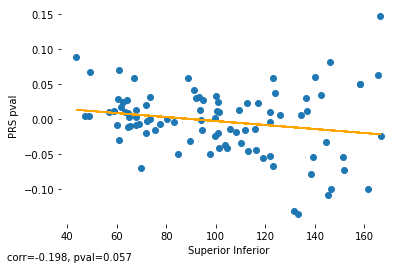

In [126]:
visualisation.plot_correlation(ROIs_coord.loc[0:92,'Z'],[i for i in plot_values_coefs.values()],xlabel='Superior Inferior',ylabel=r'PRS pval')
# plt.hlines(-np.log10(0.05),50,110)
sns.despine(left=True,bottom=True)

In [48]:
PRS_loading_matrix = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'] == 'PRS_0.05'].copy()

In [50]:
PRS_loading_matrix

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
651,AAL 1,-0.002460,0.954812,-0.213639,3.173379e-07,0.254561,2.307562e-05,0.769808,3.893629e-36,-0.000308,0.992133,0.026966,0.383712,0.021551,0.475954,0.023631,0.438997,0.005199,0.937623,PRS_0.05
652,AAL 2,-0.007973,0.860977,-0.133028,1.921547e-03,0.119196,5.419926e-02,0.844140,2.695985e-38,-0.035239,0.282812,0.005494,0.865469,0.001055,0.973424,0.067665,0.035457,0.016849,0.808889,PRS_0.05
653,AAL 3,-0.010907,0.801983,-0.026476,5.131469e-01,-0.097262,9.965738e-02,0.984095,7.013667e-49,-0.014482,0.643666,-0.026857,0.386434,-0.005099,0.866201,0.023999,0.432676,0.023051,0.729100,PRS_0.05
654,AAL 4,0.016778,0.717550,-0.006445,8.812817e-01,-0.012503,8.421366e-01,0.884703,1.047109e-39,0.030596,0.359814,-0.065234,0.049425,-0.031146,0.335085,0.100513,0.002308,-0.035459,0.617422,PRS_0.05
655,AAL 5,0.041404,0.362899,0.031547,4.560794e-01,-0.258118,4.046016e-05,1.044196,9.688283e-50,-0.001255,0.969390,-0.050854,0.117458,-0.009735,0.758312,0.035260,0.270464,-0.087502,0.209342,PRS_0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,AAL 89,-0.007285,0.893445,0.049110,3.323918e-01,-0.092850,2.081341e-01,0.893870,1.138421e-32,0.031795,0.416994,0.019455,0.615663,-0.080458,0.034541,0.027322,0.475000,0.015396,0.853240,PRS_0.05
740,AAL 90,0.034579,0.470907,-0.015703,7.247861e-01,-0.010770,8.681508e-01,0.886522,3.575742e-38,0.014388,0.676646,0.002578,0.939811,-0.007832,0.814364,0.032160,0.340251,-0.073079,0.319657,PRS_0.05
741,AAL 91,-0.010427,0.822246,-0.070409,1.041690e-01,0.447306,1.891889e-11,0.548747,2.026056e-20,-0.001199,0.971361,0.032625,0.324332,-0.051783,0.110031,-0.015717,0.630006,0.022037,0.756370,PRS_0.05
742,AAL 92,-0.004415,0.920526,-0.070005,9.028505e-02,0.469154,2.784550e-13,0.540174,2.067144e-21,-0.015318,0.630638,0.020704,0.511553,-0.053461,0.083754,-0.017859,0.565979,0.009331,0.890406,PRS_0.05


In [66]:
len(loading_matrix[3].values[0:90])

90

In [115]:
loading_matrix = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_0.01'].copy()
loading_labels = [int(i.replace('AAL ','')) for i in loading_matrix.Connection.tolist()]
loading_values = -np.log10(loading_matrix['PRS_pval'].values)

In [116]:
loading_matrix.sort_values(by='PRS_pval').head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
715,AAL 65,0.057583,0.322873,0.068126,0.209111,0.056995,0.469508,0.747493,4.313192e-23,-0.012171,0.771312,-0.007646,0.853625,0.010234,0.800461,-0.141710,0.000639,-0.121696,0.172646,PRS_0.05
654,AAL 4,0.016778,0.717550,-0.006445,0.881282,-0.012503,0.842137,0.884703,1.047109e-39,0.030596,0.359814,-0.065234,0.049425,-0.031146,0.335085,0.100513,0.002308,-0.035459,0.617422,PRS_0.05
707,AAL 57,-0.120853,0.011434,-0.066698,0.131533,0.163821,0.011319,0.797380,1.033863e-33,-0.019395,0.569781,0.022485,0.505661,0.053695,0.104693,-0.095758,0.004438,0.255412,0.000525,PRS_0.05
716,AAL 66,0.001733,0.973025,-0.048027,0.314433,0.172421,0.013646,0.754755,4.327543e-28,-0.003976,0.914155,0.025151,0.491078,0.008041,0.821613,-0.096580,0.007870,-0.003662,0.962752,PRS_0.05
718,AAL 68,0.055392,0.201609,0.046737,0.246699,0.015491,0.791505,0.866799,3.412155e-42,0.002307,0.940973,-0.007475,0.808469,0.087928,0.003879,-0.075622,0.013643,-0.117065,0.078358,PRS_0.05
677,AAL 27,0.059168,0.273029,0.047144,0.347725,-0.089177,0.222458,0.876433,3.346754e-32,-0.048879,0.208552,-0.043600,0.256908,0.080790,0.032247,0.091582,0.016394,-0.125045,0.130606,PRS_0.05
652,AAL 2,-0.007973,0.860977,-0.133028,0.001922,0.119196,0.054199,0.844140,2.695985e-38,-0.035239,0.282812,0.005494,0.865469,0.001055,0.973424,0.067665,0.035457,0.016849,0.808889,PRS_0.05
670,AAL 20,0.006828,0.901407,-0.045576,0.374646,0.021809,0.770062,0.833619,3.756126e-29,-0.004278,0.914110,-0.068002,0.084452,0.004849,0.899400,0.080700,0.038268,-0.014431,0.864152,PRS_0.05
735,AAL 85,-0.024171,0.577430,0.089606,0.027323,-0.053974,0.358364,0.926450,1.162679e-45,-0.024054,0.441225,-0.005310,0.863534,0.007489,0.804031,-0.060326,0.048887,0.051082,0.441786,PRS_0.05
675,AAL 25,-0.003177,0.957764,0.100771,0.072184,-0.208051,0.011051,0.914307,1.826228e-29,0.022274,0.606025,-0.045150,0.291397,-0.052945,0.205635,0.082959,0.050211,0.006714,0.941693,PRS_0.05


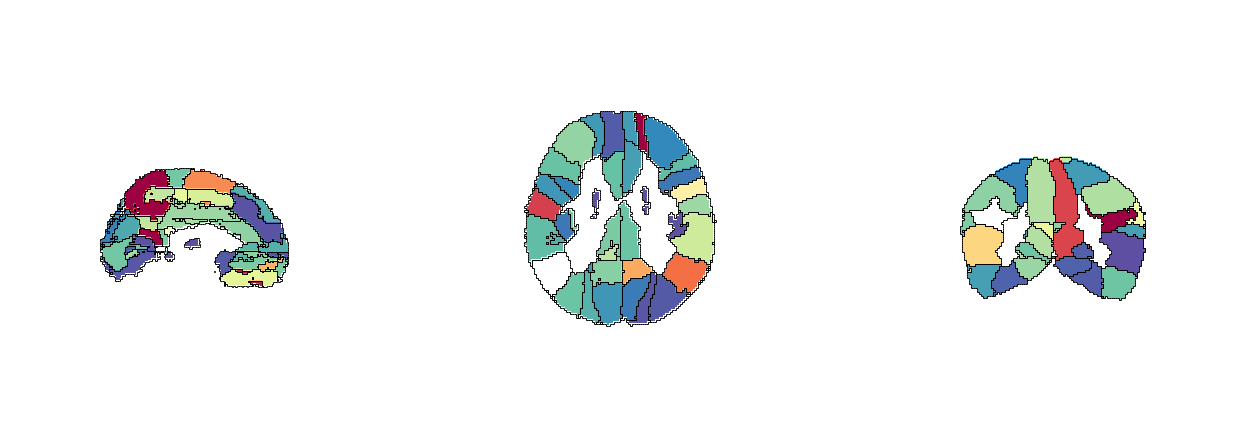

In [127]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],regions_to_hide=[65],plot_values=dict(zip(loading_labels,loading_values)),colorbar=False,atlas_file = '../../dataset/visualise/AAL/infant-neo-aal.nii.gz',orientation='vertical',cmap_reversed=True)

In [29]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/infant-neo-aal.nii.gz')

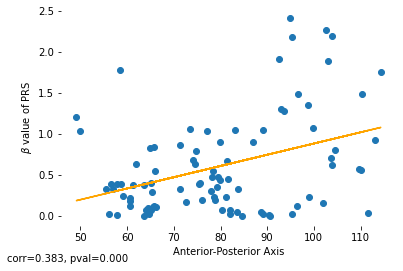

In [34]:
visualisation.plot_correlation(ROIs_coord.loc[0:89,'Z'],-np.log10(PRS_loading_matrix.loc[0:89,'PRS_pval'].values),xlabel='Anterior-Posterior Axis',ylabel=r'$\beta$ value of PRS')
# plt.hlines(-np.log10(0.05),50,110)
sns.despine(left=True,bottom=True)

In [55]:
corr_matrix = []
adjusted_X = []
dependentVar_cols = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('AAL \d', i))
]
for region in dependentVar_cols:
    model,_ = data_exploration.MassUnivariate.mass_univariate(df,
                                                   cat_independentVar_cols=['Gender'],
                                                   cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)'],
                                                   dependentVar_cols=[region])
    adjusted_X.append(model.resid)
#     corr_matrix.append(np.corrcoef(model.resid,X_pca[:,3])[0][1])

In [56]:
adjusted_X = np.array(adjusted_X).T

In [57]:
pca, new_X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=adjusted_X,
    scaling=True,n_components=5)

In [58]:
# df = european_volumetric_dataset_term
thresholds = [i for i in df.columns if 'PRS' in i]
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=new_X_pca)

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 48.04it/s]


In [59]:
0.05/3/7

0.0023809523809523807

In [60]:
european_volumetric_term_mass_univariate.sort_values(by=['PRS_pval'])

,Connection,const_coef,const_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,threshold
32,Dependent_Var_2,-2.081668e-17,1.0,0.033502,0.631681,-0.033370,0.635315,-0.186442,0.007041,0.228531,0.001106,PRS_0.01
37,Dependent_Var_2,-2.081668e-17,1.0,0.033507,0.633447,-0.023221,0.741611,-0.171490,0.013178,0.204770,0.003291,PRS_0.05
27,Dependent_Var_2,-2.081668e-17,1.0,0.034443,0.625896,-0.021720,0.758968,-0.175738,0.011565,0.182320,0.009221,PRS_0.001
21,Dependent_Var_1,6.938894e-18,1.0,-0.008720,0.903107,0.036521,0.610057,-0.032718,0.642183,-0.165663,0.019203,PRS_0.0001
42,Dependent_Var_2,-2.081668e-17,1.0,0.033369,0.637939,-0.028260,0.692753,-0.168661,0.015538,0.163711,0.020446,PRS_0.1
52,Dependent_Var_2,-2.081668e-17,1.0,0.037301,0.599672,-0.020498,0.773068,-0.172077,0.013650,0.162629,0.020790,PRS_1
47,Dependent_Var_2,-2.081668e-17,1.0,0.037336,0.599819,-0.016551,0.815676,-0.172730,0.013411,0.156438,0.025947,PRS_0.5
23,Dependent_Var_3,6.938894e-18,1.0,-0.046485,0.517298,-0.032169,0.653801,0.020202,0.774521,-0.157441,0.026209,PRS_0.0001
12,Dependent_Var_2,-2.081668e-17,1.0,0.020179,0.776040,-0.003347,0.962330,-0.181380,0.009979,0.141322,0.043111,PRS_1e-06
17,Dependent_Var_2,-2.081668e-17,1.0,0.030262,0.670559,-0.017867,0.802297,-0.170962,0.014627,0.137189,0.050820,PRS_1e-05


In [47]:
loading_values = loading_matrix.loc[0:89,2].values

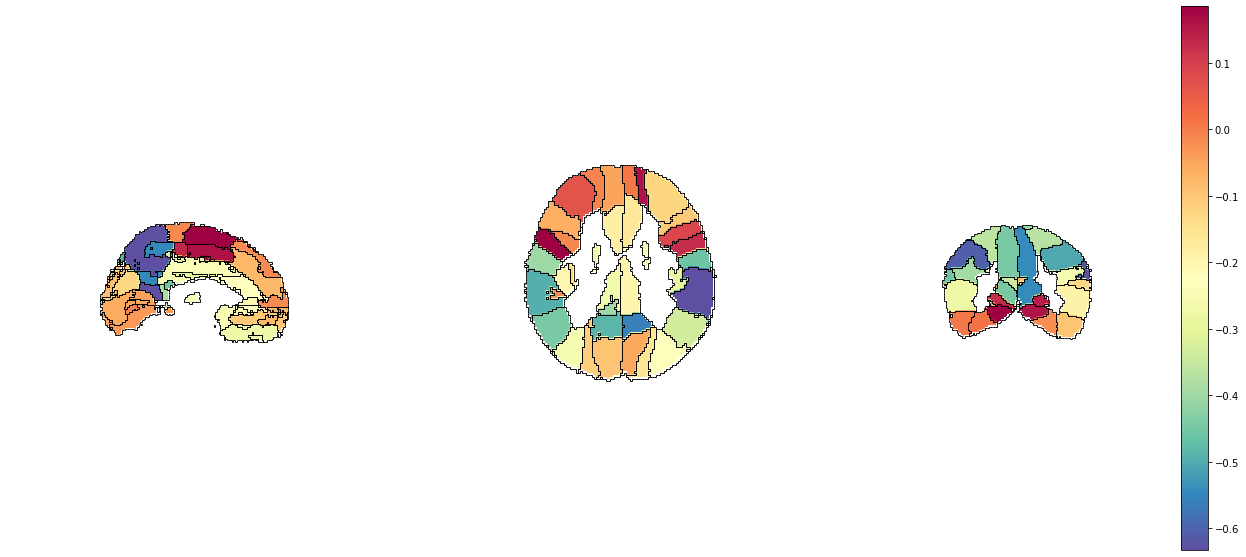

In [43]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],plot_values_labels=list(range(1,91)),plot_values_values=loading_values,colorbar=True,atlas_file = '../../dataset/visualise/AAL/infant-neo-aal.nii.gz',orientation='vertical',cmap_reversed=True)

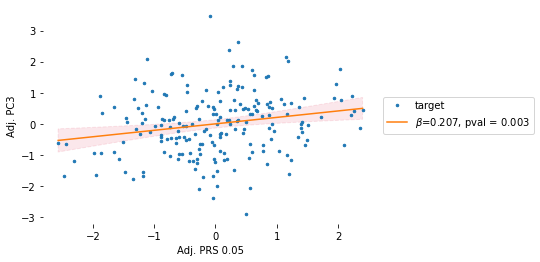

In [54]:
# PC4 was associated with the PRS 0.01 and 0.05
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_0.05'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, new_X_pca[:,2], xlabel='Adj. PRS 0.05', ylabel='Adj. PC3',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [5]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/infant-neo-aal.nii.gz')

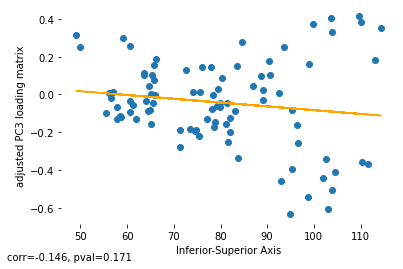

In [55]:
visualisation.plot_correlation(ROIs_coord.loc[0:89,'Z'],loading_values,xlabel='Inferior-Superior Axis',ylabel=r'adjusted PC3 loading matrix')
# plt.hlines(-np.log10(0.05),50,110)
sns.despine(left=True,bottom=True)

## Imperial Atlas

In [22]:
df.shape

(205, 4520)

In [127]:
df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping='gmwm2gether',remove_duplicated=False)
deepGM = data_preprocessing.Volumes.extract_deepGM_Imperial([i for i in df.columns if bool(re.search('Imperial \d',i))])
df = df.drop(columns=['Imperial 83','Imperial 84','Imperial 85'])




In [138]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('Imperial \d',i))]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','Intracranial_Imperial']+ancestry,
    dependentVar_cols=dependentVar_cols)

100%|███████████████████████████████████████████| 22/22 [00:03<00:00,  5.90it/s]


In [139]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if 'Euro' in i]
european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval').groupby('Connection').head(1).head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
1466,Imperial 39,0.112328,0.001245,-0.023497,0.460373,0.148113,0.001599,0.818412,3.936469e-52,-0.021625,0.380113,-0.019727,0.419905,0.073000,0.002512,-0.077292,0.001754,-0.237394,0.000011,PRS_0.01_ASD_Euro_LD
1509,Imperial 82,0.112328,0.001245,-0.023497,0.460373,0.148113,0.001599,0.818412,3.936469e-52,-0.021625,0.380113,-0.019727,0.419905,0.073000,0.002512,-0.077292,0.001754,-0.237394,0.000011,PRS_0.01_ASD_Euro_LD
1465,Imperial 38,0.082651,0.019732,-0.000971,0.976260,0.124408,0.009432,0.831139,1.462638e-51,-0.006597,0.793813,-0.011510,0.646096,0.078786,0.001490,-0.068411,0.006741,-0.174675,0.001427,PRS_0.01_ASD_Euro_LD
1508,Imperial 81,0.082651,0.019732,-0.000971,0.976260,0.124408,0.009432,0.831139,1.462638e-51,-0.006597,0.793813,-0.011510,0.646096,0.078786,0.001490,-0.068411,0.006741,-0.174675,0.001427,PRS_0.01_ASD_Euro_LD
1840,Imperial 77,0.052902,0.338357,-0.052045,0.308880,0.069079,0.355244,0.799852,1.818948e-27,-0.009592,0.810847,0.021791,0.579329,0.079789,0.038647,-0.091651,0.020309,-0.111803,0.186868,PRS_1_ASD_Euro_LD
1797,Imperial 34,0.052902,0.338357,-0.052045,0.308880,0.069079,0.355244,0.799852,1.818948e-27,-0.009592,0.810847,0.021791,0.579329,0.079789,0.038647,-0.091651,0.020309,-0.111803,0.186868,PRS_1_ASD_Euro_LD
1338,Imperial 79,0.070413,0.017363,-0.013077,0.625440,-0.040457,0.302029,0.969866,6.948019e-74,-0.002795,0.892951,-0.014784,0.471285,-0.007171,0.722793,0.048796,0.021275,-0.148812,0.001285,PRS_0.0001_ASD_Euro_LD
1295,Imperial 36,0.070413,0.017363,-0.013077,0.625440,-0.040457,0.302029,0.969866,6.948019e-74,-0.002795,0.892951,-0.014784,0.471285,-0.007171,0.722793,0.048796,0.021275,-0.148812,0.001285,PRS_0.0001_ASD_Euro_LD
1296,Imperial 37,0.063475,0.031330,-0.030454,0.255035,-0.017793,0.648697,0.963212,1.384004e-73,-0.017134,0.408498,-0.025098,0.220738,-0.011625,0.564379,0.048496,0.021738,-0.134147,0.003540,PRS_0.0001_ASD_Euro_LD
1339,Imperial 80,0.063475,0.031330,-0.030454,0.255035,-0.017793,0.648697,0.963212,1.384004e-73,-0.017134,0.408498,-0.025098,0.220738,-0.011625,0.564379,0.048496,0.021738,-0.134147,0.003540,PRS_0.0001_ASD_Euro_LD


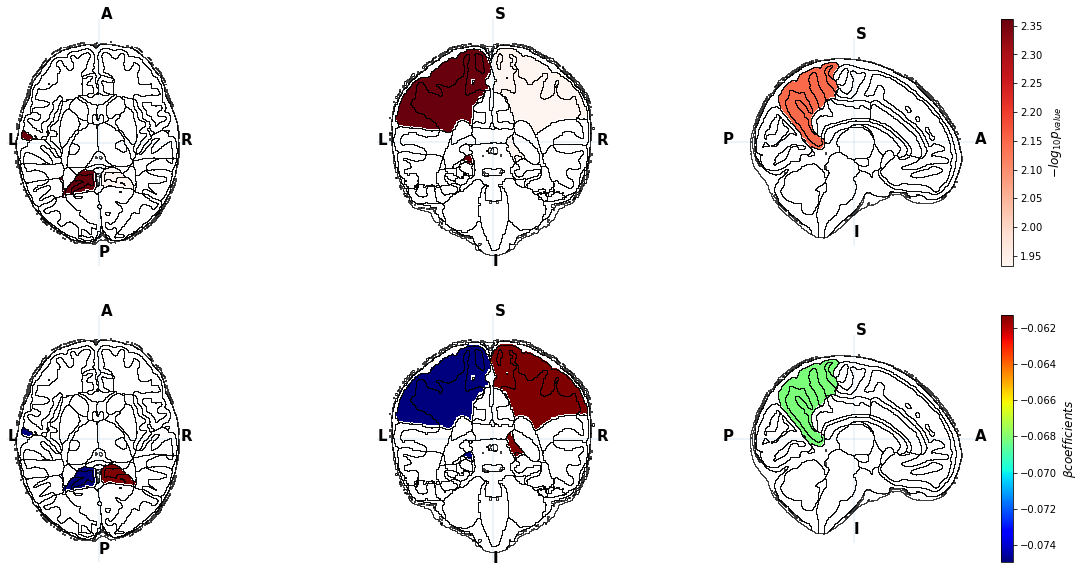

In [37]:
significant_regions = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_0.01'].copy()

plot_values_pvals = {indx+1:-np.log10(value) for indx,value in enumerate(significant_regions['PRS_pval'])}

plot_values_coefs = {indx+1:value for indx,value in enumerate(significant_regions['PRS_coef'])}

fig, axes = plt.subplots(2,3,figsize=(20,10))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['all'],
                                                              plot_values=plot_values_pvals,
                                                              plot_values_threshold=-np.log10(0.05),
                                                              axes=axes[0,:],
                                                            fig = fig,
                                                              atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',
                                                              colorbar=True,
                                                              cb_orientation='vertical',
                                                              cb_title=r'$-log_{10}p_{value}$',
                                                              cmap='Reds',
                                                              cmap_reversed=False)

_, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['all'],
                                                              plot_values=plot_values_pvals,
                                                              plot_values_threshold=-np.log10(0.05),
                                                            mask = plot_values_coefs,
                                                              axes=axes[1,:],
                                                            fig = fig,
                                                              atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',
                                                              colorbar=True,
                                                              cb_orientation='vertical',
                                                              cb_title=r'$\beta coefficients$',
                                                              cmap='jet',
                                                              cmap_reversed=False)

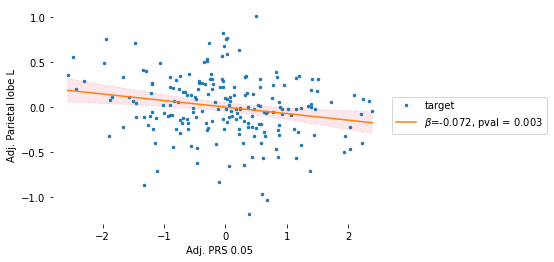

In [26]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=['Imperial 39'])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_0.05'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 0.05', ylabel='Adj. Parietal lobe L',markersize=5,scaling='x')
sns.despine(left=True,right=True,bottom=True,top=True)

In [13]:
len(combined.columns)

84

In [82]:
# euro_WM = data_preprocessing.Volumes.extract_WM_Imperial(df)
# euro_GM = data_preprocessing.Volumes.extract_GM_Imperial(df)
# euro_DGM = data_preprocessing.Volumes.extract_deepGM_Imperial(df)
# deepGM = data_preprocessing.Volumes.extract_deepGM_Imperial([i for i in df.columns if bool(re.search('Imperial \d',i))])
combined = df[[
    i for i in df.columns
    if bool(re.search('Imperial \d', i))
]].copy()
# combined.drop(columns=deepGM,inplace=True)
# combined = pd.concat([euro_WM,euro_GM],axis=1)
# combined = df[[i for i in df.columns if 'PRS' in i]]
correlation_matrix = np.corrcoef(combined, rowvar=False)
data_exploration.matSpDLite(correlation_matrix, alpha=0.05)

Effective Number of Independent Variables [Veff] is 30.537095519088055
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 20.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.002499999999999996


In [155]:
dependentVar_cols = [
    i for i in df.columns
    if bool(re.search('Imperial \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components=.8)

In [141]:
0.05/7/7

0.0010204081632653062

In [142]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('Imperial \d',i))]


european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','Intracranial_Imperial']+ancestry,
    dependentVar_cols=X_pca)

100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 42.98it/s]


In [145]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if 'Euro' in i]


european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
87,Dependent_Var_3,0.104430,0.251763,-0.020866,0.804448,-0.463442,0.000239,0.237552,2.354691e-02,0.204492,0.002088,0.115645,0.074491,-0.039549,0.534357,0.131863,0.042549,-0.220702,0.113944,PRS_1e-07_ASD_Euro_LD
80,Dependent_Var_3,0.108964,0.231672,-0.037402,0.658978,-0.459112,0.000283,0.236233,2.451209e-02,0.200315,0.002511,0.119052,0.066340,-0.039214,0.537990,0.127802,0.047279,-0.230285,0.098819,PRS_1e-08_ASD_Euro_LD
149,Dependent_Var_2,-0.081308,0.417484,0.025639,0.782196,0.173632,0.201024,0.006898,9.518182e-01,-0.041379,0.569712,0.043653,0.540774,0.059069,0.396940,-0.133021,0.062920,0.171836,0.263524,PRS_1_ASD_Euro_LD
142,Dependent_Var_2,-0.082056,0.413990,0.027009,0.771257,0.169900,0.211437,0.008764,9.389353e-01,-0.039277,0.589922,0.040846,0.567201,0.060443,0.386892,-0.120960,0.090753,0.173417,0.260008,PRS_0.5_ASD_Euro_LD
92,Dependent_Var_1,0.099867,0.316180,-0.115315,0.213224,0.407979,0.002800,-0.375062,1.185582e-03,0.009832,0.890691,-0.044773,0.526480,-0.013230,0.849348,-0.114803,0.101839,-0.211058,0.166297,PRS_1e-06_ASD_Euro_LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Dependent_Var_5,-0.204175,0.043317,0.201145,0.031601,-0.259688,0.057245,0.146808,2.008253e-01,0.068408,0.349191,0.029579,0.679433,-0.012761,0.855130,-0.005125,0.942812,0.431503,0.005509,PRS_1_ASD_Euro_LD
97,Dependent_Var_6,0.067821,0.493708,0.017185,0.851857,-0.329783,0.014813,0.202608,7.563492e-02,-0.037027,0.603142,-0.133812,0.058184,-0.050672,0.465053,0.004268,0.951104,-0.143332,0.344273,PRS_1e-06_ASD_Euro_LD
119,Dependent_Var_0,0.080262,0.003056,-0.052990,0.033800,0.120311,0.001032,0.876817,1.646798e-72,-0.001015,0.957854,-0.010528,0.581091,-0.002878,0.877267,-0.001007,0.957800,-0.169625,0.000054,PRS_0.01_ASD_Euro_LD
150,Dependent_Var_3,0.112500,0.222382,-0.020605,0.808835,-0.493122,0.000102,0.258901,1.426715e-02,0.191857,0.004489,0.120594,0.066829,-0.026836,0.674970,0.003045,0.962869,-0.237757,0.092744,PRS_1_ASD_Euro_LD


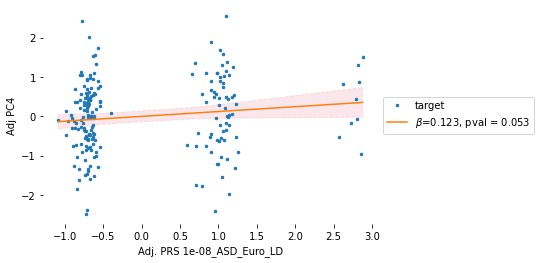

In [150]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=X_pca[:,3].reshape(-1,1))
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_1e-08_ASD_Euro_LD'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 1e-08_ASD_Euro_LD',ylabel='Adj PC4',markersize=5,scaling='x')
sns.despine(left=True,right=True,bottom=True,top=True)

In [156]:
loading_values = loading_matrix[3].values
loading_labels = [int(i.replace('Imperial ','')) for i in loading_matrix.index.tolist()]

In [152]:
loading_matrix = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_1e-07_ASD_Euro_LD'].copy()

In [153]:
loading_labels = [int(i.replace('Imperial ','')) for i in loading_matrix.Connection.tolist()]
loading_values = -np.log10(loading_matrix['PRS_pval'].values)

ValueError: invalid literal for int() with base 10: 'Dependent_Var_0'

In [159]:
plot_values=dict(zip(loading_labels,loading_values))

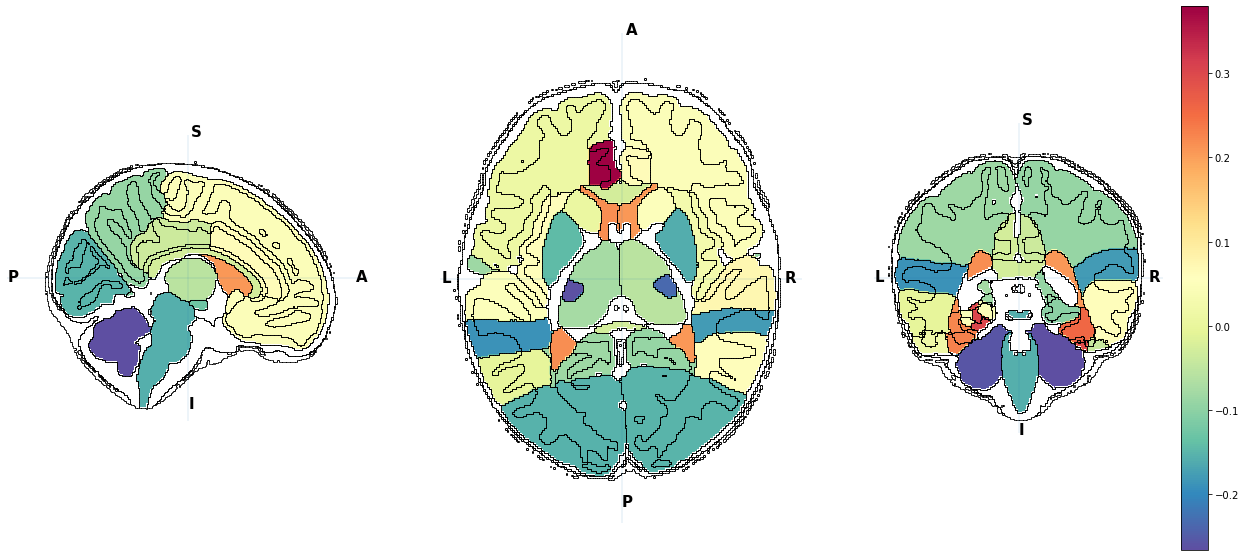

In [161]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],regions_to_hide=[83,84,85],plot_values=dict(zip(loading_labels,loading_values)),colorbar=True,atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',orientation='vertical',cmap_reversed=True)

In [102]:
loading_matrix.sort_values(by='PRS_pval').head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
626,Imperial 39,0.106360,0.002147,-0.023500,0.460970,0.145867,0.001887,0.821106,3.166235e-52,-0.021323,0.387317,-0.022125,0.364891,0.068321,0.004547,-0.074275,0.002290,-0.224782,0.000027,PRS_0.05
669,Imperial 82,0.106360,0.002147,-0.023500,0.460970,0.145867,0.001887,0.821106,3.166235e-52,-0.021323,0.387317,-0.022125,0.364891,0.068321,0.004547,-0.074275,0.002290,-0.224782,0.000027,PRS_0.05
625,Imperial 38,0.077725,0.027281,-0.001627,0.960144,0.122770,0.010193,0.833785,7.581033e-52,-0.006690,0.790535,-0.013127,0.598618,0.074751,0.002419,-0.071013,0.004271,-0.164265,0.002429,PRS_0.05
668,Imperial 81,0.077725,0.027281,-0.001627,0.960144,0.122770,0.010193,0.833785,7.581033e-52,-0.006690,0.790535,-0.013127,0.598618,0.074751,0.002419,-0.071013,0.004271,-0.164265,0.002429,PRS_0.05
594,Imperial 7,0.103206,0.116151,-0.130023,0.033834,0.331447,0.000239,0.524381,3.301860e-11,0.007316,0.876638,-0.081357,0.082343,-0.047043,0.302648,0.072285,0.117424,-0.218116,0.030473,PRS_0.05
640,Imperial 53,0.103206,0.116151,-0.130023,0.033834,0.331447,0.000239,0.524381,3.301860e-11,0.007316,0.876638,-0.081357,0.082343,-0.047043,0.302648,0.072285,0.117424,-0.218116,0.030473,PRS_0.05
589,Imperial 2,0.055418,0.420161,0.020557,0.747719,-0.019350,0.835210,0.744486,6.750234e-18,-0.014436,0.770296,0.001933,0.968490,0.049428,0.301845,-0.075442,0.119272,-0.117120,0.265883,PRS_0.05
607,Imperial 20,0.100870,0.055257,-0.027963,0.566227,0.002207,0.975178,0.832929,3.224413e-31,0.027544,0.465254,-0.012880,0.729998,-0.046134,0.206612,0.057497,0.119455,-0.213179,0.008379,PRS_0.05
650,Imperial 63,0.100870,0.055257,-0.027963,0.566227,0.002207,0.975178,0.832929,3.224413e-31,0.027544,0.465254,-0.012880,0.729998,-0.046134,0.206612,0.057497,0.119455,-0.213179,0.008379,PRS_0.05
616,Imperial 29,0.004149,0.935496,0.098326,0.040297,-0.128259,0.065803,0.929503,3.513508e-37,-0.013221,0.720120,0.028633,0.433366,-0.003974,0.911304,-0.053962,0.135315,-0.008768,0.910997,PRS_0.05


In [162]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates(atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz')

In [163]:
ROIs_coord = ROIs_coord[~ROIs_coord['Label'].isin([83,84,85])]

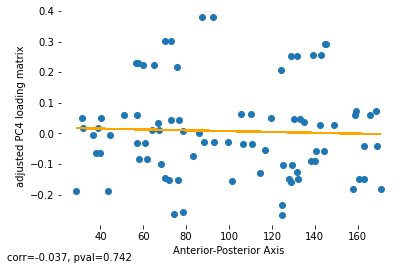

In [167]:
visualisation.plot_correlation(ROIs_coord['X'],loading_values,xlabel='Anterior-Posterior Axis',ylabel=r'adjusted PC4 loading matrix')
# plt.hlines(-np.log10(0.05),50,110)
sns.despine(left=True,bottom=True)

In [ ]:
df = mixed_volumetric_dataset_term
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
thresholds = [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]

summary_table = data_exploration.MassUnivariate.print_summary_table(df,
                                                    cat_independentVar_cols=['Gender'],
                                                    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']
                                                                    + ancestry_list,
                                                    dependentVar_cols=dependentVar_cols,
                                                    thresholds=thresholds)

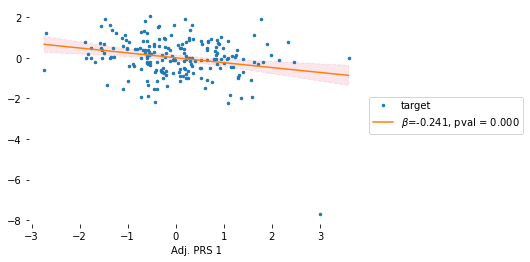

In [149]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=['Imperial 38'])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_1e-06'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 1',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

We get the following summary table of R2, beta and p-value of association between PRS and brain volumes

In [14]:
df = mixed_volumetric_dataset_term
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
thresholds = [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]

summary_table = data_exploration.MassUnivariate.print_summary_table(df,
                                                    cat_independentVar_cols=['Gender'],
                                                    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']
                                                                    + ancestry_list,
                                                    dependentVar_cols=['Imperial 79', 'Imperial 58', 'Imperial 12', 'WM_sum_Imperial'],
                                                    thresholds=thresholds)

In [15]:
summary_table

GA_vol       PMA_vol  \
Imperial 79     PRS_1e-08 R2     2.151483e-07  5.581806e-02   
                          Beta   1.163305e-03 -4.655917e-01   
                          P_val  9.737014e-01  2.193130e-16   
                PRS_1e-07 R2     2.151483e-07  5.581806e-02   
                          Beta  -4.715114e-05 -4.633134e-01   
...                                       ...           ...   
WM_sum_Imperial PRS_0.5   Beta  -2.090412e-02 -3.504964e-01   
                          P_val  4.976230e-01  7.648056e-13   
                PRS_1     R2     2.069066e-04  3.168293e-02   
                          Beta  -2.117077e-02 -3.491695e-01   
                          P_val  4.918391e-01  9.191190e-13   

                                 Intracranial_Imperial  mixed_Anc_PC1  \
Imperial 79     PRS_1e-08 R2              4.345161e-01       0.000042   
                          Beta            1.111430e+00       0.001041   
                          P_val           1.504568e-69       0.972560   
                PRS_1e-07 R2              4.345161e-01       0.000042   
                          Beta            1.109018e+00      -0.000937   
...                                                ...            ...   
WM_sum_Imperial PRS_0.5   Beta            1.092073e+00      -0.000195   
                          P_val           1.989428e-78       0.995132   
                PRS_1     R2              4.196961e-01       0.000481   
                          Beta            1.090843e+00      -0.002398   
                          P_val           2.625290e-78       0.940021   

                                 mixed_Anc_PC2  mixed_Anc_PC3  mixed_Anc_PC4  \
Imperial 79     PRS_1e-08 R2          0.000154       0.001059       0.000422   
                          Beta       -0.029123      -0.063549       0.024028   
                          P_val       0.570351       0.226530       0.406298   
                PRS_1e-07 R2          0.000154       0.001059       0.000422   
                          Beta       -0.028789      -0.063398       0.024302   
...                                        ...            ...            ...   
WM_sum_Imperial PRS_0.5   Beta        0.024430       0.001851       0.022922   
                          P_val       0.585327       0.968076       0.363892   
                PRS_1     R2          0.000128       0.000014       0.000426   
                          Beta        0.024602       0.002582       0.022865   
                          P_val       0.582377       0.955443       0.364681   

                                 mixed_Anc_PC5  Gender  PRS_1e-08  ...  \
Imperial 79     PRS_1e-08 R2          0.000126     0.0   0.000000  ...   
                          Beta       -0.009900     NaN  -0.074038  ...   
                          P_val       0.721709     NaN   0.005687  ...   
                PRS_1e-07 R2          0.000126     0.0        NaN  ...   
                          Beta       -0.010466     NaN        NaN  ...   
...                                        ...     ...        ...  ...   
WM_sum_Imperial PRS_0.5   Beta       -0.020695     NaN        NaN  ...   
                          P_val       0.394847     NaN        NaN  ...   
                PRS_1     R2          0.000294     0.0        NaN  ...   
                          Beta       -0.020826     NaN        NaN  ...   
                          P_val       0.391380     NaN        NaN  ...   

                                 PRS_1e-07  PRS_1e-06  PRS_1e-05  PRS_0.0001  \
Imperial 79     PRS_1e-08 R2           NaN        NaN        NaN         NaN   
                          Beta         NaN        NaN        NaN         NaN   
                          P_val        NaN        NaN        NaN         NaN   
                PRS_1e-07 R2      0.000000        NaN        NaN         NaN   
                          Beta   -0.076941        NaN        NaN         NaN   
...                                    ...        ...        ...         ..

We get the following plots

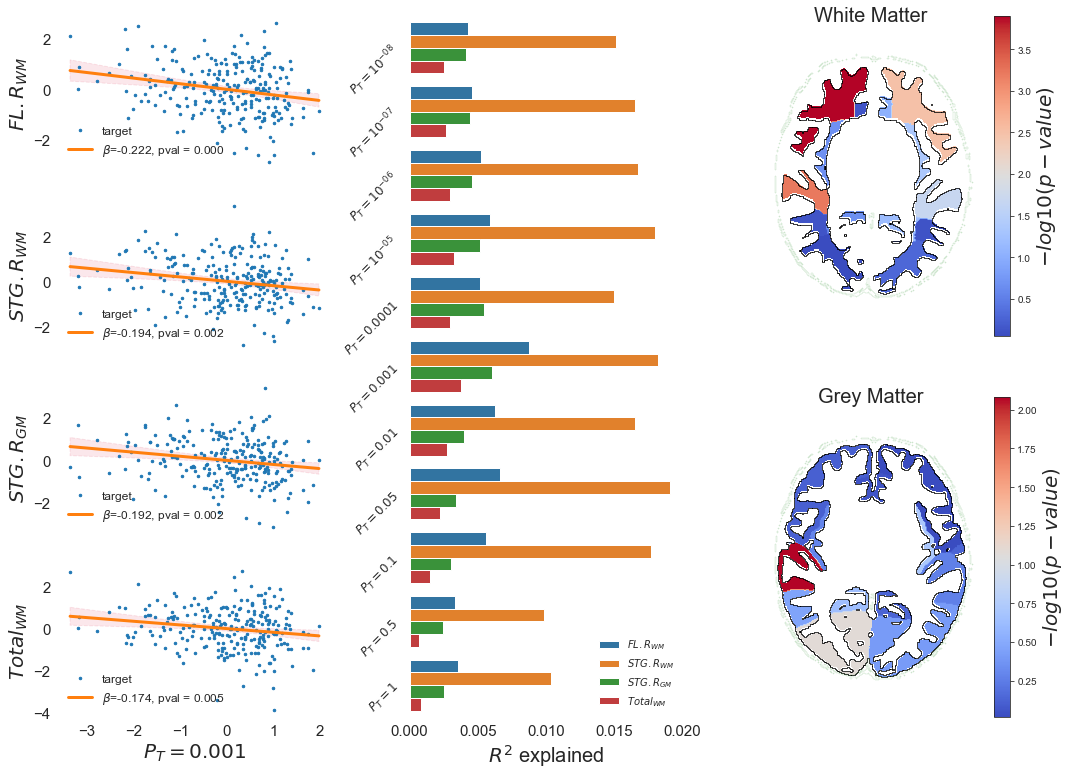

In [138]:
sns.set_style('white')
fig,axes = plt.subplots(4,3,sharex = True,figsize=(15,11))
# fig = plt.figure(figsize=(20,10))
# ax1 = plt.subplot(4,3,1)
# ax2 = plt.subplot(4,3,4)
# ax3 = plt.subplot(4,3,7)
# ax4 = plt.subplot(4,3,10)
for ax in axes[:,1:].flatten():
    ax.remove()
bar_plot = plt.subplot(132)
WM_plot = plt.subplot(233)
GM_plot = plt.subplot(236)
# plt.tight_layout(w_pad =.5, h_pad=.2)
dependent_var = ['Imperial 79','Imperial 58','Imperial 12','WM_sum_Imperial']
ylbl = ['$FL.R_{WM}$', '$STG.R_{WM}$', '$STG.R_{GM}$','$Total_{WM}$']
threshold = 'PRS_0.001'
thresholds_label = '$P_T = 0.001$'
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1,4)]
# axes = axes.flatten()
df = mixed_volumetric_dataset_term
# draw the scatter plot
for ax,dependent_variable, ylabel in zip(axes[:,0],dependent_var,ylbl):
    model, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                              cat_independentVar_cols=['Gender'],
                                                              cont_independentVar_cols=[
                                                                  'GA_vol','PMA_vol','Intracranial_Imperial'
                                                              ]+ancestry_list,
                                                              dependentVar_cols=[dependent_variable])
    visualisation.plot_Linear_Reg(x = df[[threshold]].values,
                                 y = model.resid.values,
                                 data = df,
                                 ylabel = ylabel,
                                 xlabel = f'{threshold}',
                                 axes=ax,legend_loc='inside',linewidth = 3,markersize=5)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(None,fontsize=20)
    ax.tick_params(axis='both',which='major',labelsize=15)
    ax.legend(loc='lower left',fontsize=12,frameon=False)
    sns.despine(bottom=True,left=True,right=True)
axes[-1,0].set_xlabel(f'{thresholds_label}',fontsize=20)

    
#draw the barplot of R-squared explained
Rsquared_explained_list = defaultdict(dict)
for dependent_variable in dependent_var:
    Rsquared_explained_list[dependent_variable] = defaultdict(list)
    for threshold in [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]:
        Rsquared_explained_list[dependent_variable][threshold] = data_exploration.MassUnivariate.calculate_R_squared_explained(df = df,col_to_drop=threshold,cat_independentVar_cols=['Gender'],cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry_list,dependentVar_cols=[dependent_variable])
Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_list)
Rsquared_explained_pd.columns = ylbl

Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_pd.unstack()).reset_index()
Rsquared_explained_pd.columns = ['Region','Threshold','$R^{2}$ explained']

g = sns.barplot(y = 'Threshold',x = '$R^{2}$ explained', data = Rsquared_explained_pd,hue = 'Region',ax = bar_plot)
# g.set_xlabel(rotation=90)
sns.despine(bottom=True,left=True,right=True)
bar_plot.set_xlabel('$R^{2}$ explained',fontsize=20)
bar_plot.set_ylabel(None,fontsize=20)
g.set_yticklabels(['$P_T = 10^{-08}$','$P_T = 10^{-07}$',
                     '$P_T = 10^{-06}$','$P_T = 10^{-05}$',
                     '$P_T = 0.0001$','$P_T = 0.001$',
                     '$P_T = 0.01$','$P_T = 0.05$',
                    '$P_T = 0.1$','$P_T = 0.5$','$P_T = 1$'],fontsize=12,rotation = 45)
g.tick_params(axis='x', labelsize=15)
bar_plot.legend(frameon=False)

#import the atlas
import nibabel as nib
FOLDER_PATH = f'{dataset_path}/visualise/Imperial/'  # please change to your own path

atlas_file = nib.load(FOLDER_PATH + 'atlas_t40.nii.gz')
atlas_aff = atlas_file.affine
atlas = atlas_file.get_fdata()

df = mixed_volumetric_term_mass_univariate[mixed_volumetric_term_mass_univariate['threshold'] == 'PRS_0.001'].copy()

df = df[[bool(re.search(r'[1-9]',i)) for i in df['Connection']]].sort_values(by='PRS_pval').reset_index(drop=True)
df['Connection_ID'] = [int(i.split(' ')[1]) for i in df['Connection']]

# Create a new volume of the same size as the atlas
atlas_coeffs_WM = np.zeros_like(atlas)
atlas_coeffs_GM = np.zeros_like(atlas)


WM_df = extract_WM_Imperial(df).reset_index(drop=True)
GM_df = extract_GM_Imperial(df).reset_index(drop=True)
# fig,axes = plt.subplots(1,2,figsize=(20,10))
# Here you will replace each index (0...87) from the atlas with the coefficients you want to plot
for i in WM_df['Connection_ID'].tolist():
    atlas_coeffs_WM[atlas == i] = -np.log10(WM_df.loc[WM_df['Connection_ID'] == i,'PRS_pval'].values)

for i in GM_df['Connection_ID'].tolist():
    atlas_coeffs_GM[atlas == i] = -np.log10(GM_df.loc[GM_df['Connection_ID'] == i,'PRS_pval'].values)


# im1 = WM_plot.imshow(np.rot90(atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]),cmap='coolwarm')
# im2 = GM_plot.imshow(np.rot90(atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]),cmap='coolwarm')

import copy
from matplotlib.collections import LineCollection

cmap = copy.copy(plt.cm.get_cmap('coolwarm'))
cmap.set_bad(alpha=0)

# atlas_coeffs_WM[atlas==84] = 0.1
WM_atlas = atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]
GM_atlas = atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]

WM_atlas[WM_atlas==0] = np.nan
GM_atlas[GM_atlas==0] = np.nan

im1 = WM_plot.imshow(np.rot90(WM_atlas),cmap=cmap)
im2 = GM_plot.imshow(np.rot90(GM_atlas),cmap=cmap)

WM_atlas[np.isnan(WM_atlas)] = 0
GM_atlas[np.isnan(GM_atlas)] = 0

brain_background = np.zeros(atlas.shape)
brain_background[atlas==84] = 1
brain_background = brain_background[:, :, brain_background.shape[2]//2]

cl_WM = LineCollection(visualisation.get_edges(np.rot90(WM_atlas)),lw=1,color='k')
WM_plot.add_collection(cl_WM)

cl_GM = LineCollection(visualisation.get_edges(np.rot90(GM_atlas)),lw=1,color='k')
GM_plot.add_collection(cl_GM)


cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
WM_plot.add_collection(cl_background)
cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
GM_plot.add_collection(cl_background)

for im,ax in zip([im1,im2],[WM_plot,GM_plot]):
    cbar = plt.colorbar(im,ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar.set_label('$-log10(p-value)$', fontsize=20)
WM_plot.set_title('White Matter',fontsize=20)
GM_plot.set_title('Grey Matter', fontsize=20)
# WM_plot.set_ylabel('White Matter',fontsize=20)
# GM_plot.set_ylabel('Grey Matter',fontsize=20)
plt.tight_layout()
fig.savefig(f'{preprocessed_dataset_path}/output_plot/all_plots_mixed.svg')

# Other tests

## Stability test

1. We halve the sample into 2 equal data sets and see if similar results are given
2. We separate into high and low risks

### Halving the samples

In [45]:
common_list_WM = defaultdict(pd.DataFrame)
common_list_GM = defaultdict(pd.DataFrame)
ancestry = ['mixed_Anc_PC'+str(i) for i in range(1,6)]
df = mixed_volumetric_dataset_term
thresholds = [i for i in mixed_volumetric_dataset_term.columns if 'PRS' in i]
result_dict = defaultdict(dict)
for run in range(10):
    result_dict[f'split_{run+1}']=defaultdict(dict)
    for threshold in thresholds:
        result_dict[f'split_{run+1}'][threshold]=defaultdict(dict)
        result_dict[f'split_{run+1}'][threshold]['Set_1']=defaultdict(dict)
        result_dict[f'split_{run+1}'][threshold]['Set_2']=defaultdict(dict)
        
        train, test = data_exploration.train_test_split_modified(
            df,
            'GA_vol',
            'Gender',
            'cohort',
            random_state=run)
        _,train_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            train, cat_independentVar_cols=['Gender'],
            cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry,
            dependentVar_cols=['WM_sum_Imperial','Imperial 79','Imperial 58','Imperial 12'])

        _,test_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            test, cat_independentVar_cols=['Gender'], cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry,
            dependentVar_cols=['WM_sum_Imperial','Imperial 79','Imperial 58','Imperial 12'])
        train_mass_univariate = train_mass_univariate.rename({threshold+'_pval':'PRS_pval',
                                 threshold+'_coef':'PRS_coef'},axis=1)
        test_mass_univariate = test_mass_univariate.rename({threshold+'_pval':'PRS_pval',
                                 threshold+'_coef':'PRS_coef'},axis=1)
        
        for col,colname in zip(train_mass_univariate.index.tolist(),['Total WM',
                                                                    'FL.R_WM',
                                                                    'STG.R_WM',
                                                                    'STG.R_GM']):
            result_dict[f'split_{run+1}'][threshold]['Set_1'][colname]['p_value'] = train_mass_univariate.loc[col,'PRS_pval']
            result_dict[f'split_{run+1}'][threshold]['Set_1'][colname]['beta'] = train_mass_univariate.loc[col,'PRS_coef']
            result_dict[f'split_{run+1}'][threshold]['Set_2'][colname]['p_value'] = test_mass_univariate.loc[col,'PRS_pval']
            result_dict[f'split_{run+1}'][threshold]['Set_2'][colname]['beta'] = test_mass_univariate.loc[col,'PRS_coef']

In [46]:
halving_samples = pd.DataFrame.from_dict({(s, t, st, bv): result_dict[s][t][st][bv]
                        for s in result_dict.keys()
                        for t in result_dict[s].keys()
                        for st in result_dict[s][t].keys()
                        for bv in result_dict[s][t][st].keys()},orient='index')

In [51]:
#halving_samples.to_excel('halving_samples.xlsx')

### High and low risk

In [146]:
df = mixed_volumetric_dataset_term
ancestry_PCs = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
threshold = 'PRS_0.001'
dependentVar = ['Imperial 79','Imperial 58','Imperial 12','WM_sum_Imperial']


def high_low_risk_for_catplot(df, dependentVar, ancestry_PCs, threshold, perc):
    high_risk, low_risk = data_exploration.divide_high_low_risk(
        data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
            np.asarray(df[threshold]), df[ancestry_PCs]),
        low_perc=perc,
        high_perc=perc)
    temp_high_risk = df.loc[high_risk, dependentVar].reset_index(drop=True)
    temp_high_risk['Percentages'] = perc
    temp_high_risk['Risk'] = 'High'
    temp_low_risk = df.loc[low_risk, dependentVar].reset_index(drop=True)
    temp_low_risk['Percentages'] = perc
    temp_low_risk['Risk'] = 'Low'
    return pd.concat([temp_high_risk, temp_low_risk])


risk_df = pd.concat([
    high_low_risk_for_catplot(df, dependentVar, ancestry_PCs, threshold, perc) for perc in [0.1,0.2,0.3,0.4]])
risk_df = risk_df.reset_index(drop=True)

In [153]:
df = european_volumetric_dataset_term
ancestry_PCs = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
threshold = 'PRS_0.001'
high_risk, low_risk = data_exploration.divide_high_low_risk(
        data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
            np.asarray(df[threshold]), df[ancestry_PCs]),
        low_perc=0.1,
        high_perc=0.1)

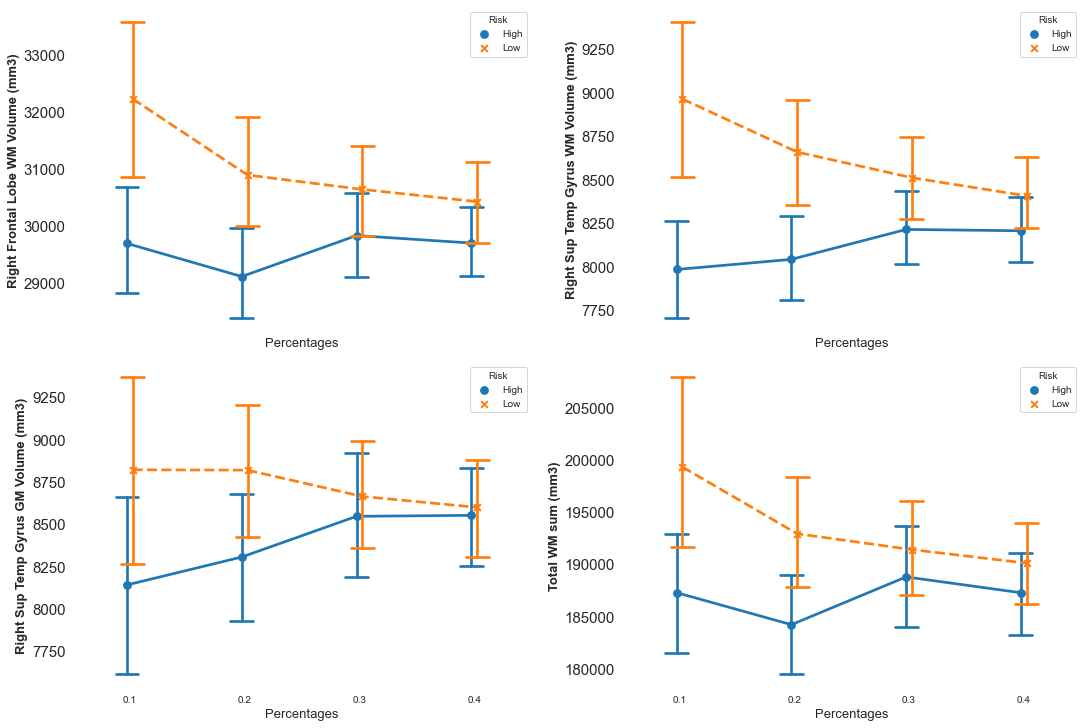

In [144]:
fig,axes = plt.subplots(2,2,figsize=(15,10),constrained_layout=True,sharex=True)
# axes[1,1].remove()
axes = axes.flatten()
for ax, variable,var_name in zip(axes,dependentVar,['Right Frontal Lobe WM Volume (mm3)',
                                                   'Right Sup Temp Gyrus WM Volume (mm3)',
                                                   'Right Sup Temp Gyrus GM Volume (mm3)',
                                                   'Total WM sum (mm3)']):
    sns.pointplot(x='Percentages',
                  y=variable,
                  data=risk_df,
                  hue='Risk',
                  dodge=True,
                 markers=['o','x'],
                 linestyles=['-','--'],capsize=.2,ax=ax)
    sns.despine(top=True,bottom=True,right=True,left=True)
    ax.set_ylabel(var_name,fontdict={'fontsize':13,'fontweight':'bold'})
    ax.set_xlabel('Percentages',fontdict={'fontsize':13})
    ax.tick_params(axis='y', labelsize=15)
# plt.savefig(f'{preprocessed_dataset_path}/output_plot/high_low_risk_european.svg')

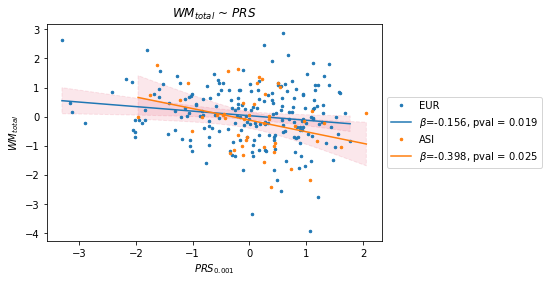

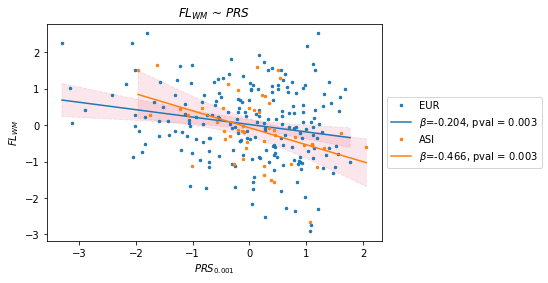

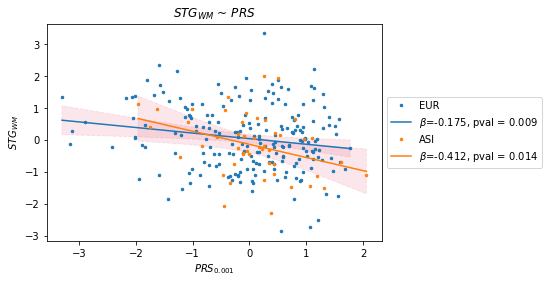

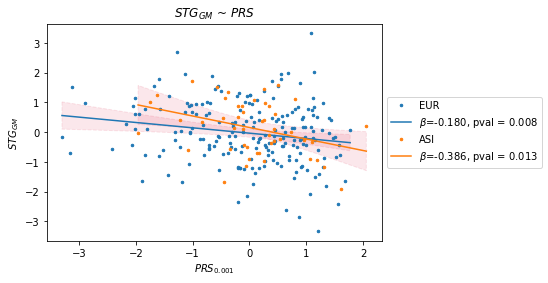

In [11]:
dependent_var = [
    'WM_sum_Imperial', 'Imperial 79', 'Imperial 58', 'Imperial 12'
]
ylbl = ['$WM_{total}$', '$FL_{WM}$', '$STG_{WM}$', '$STG_{GM}$']
ancestry = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
df = mixed_volumetric_dataset_term

for var, ylabel in (zip(dependent_var, ylbl)):
    model, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=[
            'GA_vol', 'PMA_vol', 'Intracranial_Imperial'
        ],
        dependentVar_cols=[var])
    model2, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cont_independentVar_cols=ancestry,
        dependentVar_cols=['PRS_0.001'])
#     plt.style.use('seaborn-whitegrid')
    visualisation.plot_Linear_Reg(
        model2.resid.values,
        model.resid.values,
        data=mixed_volumetric_dataset_term,
        ylabel=ylabel,
        xlabel='$PRS_{0.001}$',
        hue='cohort',
        title='%s ~ $PRS$' % ylabel,
        combined=False,
    markersize=5)

## Other tests

### check if removing or adding variables changes the R2

In [13]:
all_models = data_exploration.MassUnivariate.check_all_predictors_combo_linear_Reg(df = mixed_volumetric_dataset_term,
                                           cat_independentVar_cols=['Gender'],
                                           cont_independentVar_cols=['PRS_0.001','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3',
                                                                     'mixed_Anc_PC4','mixed_Anc_PC5',
                                                                    'GA_vol','PMA_vol','Intracranial_Imperial'],
                                          dependentVar_cols=['WM_sum_Imperial'])

100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]


In [15]:
model_score_summary, model_var_summary, model_beta_summary, model_p_summary = data_exploration.MassUnivariate.preprocess_forward_selection(all_models)

The best model is when including all the covariates, but with less it still achieves similar results

In [22]:
model_score_summary.sort_values(by='R2',ascending=False)

,N_var,AIC,R2,R2_adj
1023,10,215.648386,8.756160e-01,8.705597e-01
1018,9,213.648958,8.756157e-01,8.710835e-01
1020,9,213.742773,8.755703e-01,8.710364e-01
994,8,211.747326,8.755681e-01,8.715541e-01
1019,9,213.916692,8.754860e-01,8.709491e-01
...,...,...,...,...
7,1,731.878817,5.647762e-03,1.748342e-03
47,2,735.165348,6.575971e-04,-7.211241e-03
8,1,733.195754,5.393560e-04,-3.380098e-03
6,1,733.309411,9.725271e-05,-3.823935e-03


<AxesSubplot:xlabel='N_var'>

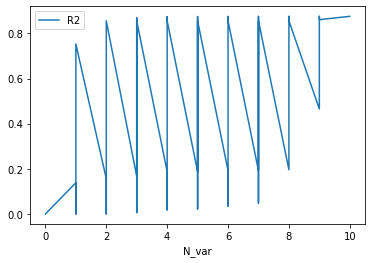

In [24]:
model_score_summary.plot('N_var','R2')

### adding preterm

In [29]:
european_volumetric_preterm_term_mass_univariate = pd.read_csv(
    './preprocessed_dataset/imaging_data/volumetric/preterm_term/european_volumetric_preterm_term_mass_univariate.csv'
)

In [32]:
data_preprocessing.Volumes.extract_WM_Imperial(european_volumetric_preterm_term_mass_univariate).sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
630,Imperial 79,0.089234,0.009166,0.222168,1.095722e-10,-0.598642,1.375070e-21,-0.036649,0.158641,-0.028282,0.262465,0.019237,0.433409,1.248126,4.956868e-67,-0.070116,0.005742,-0.197588,0.000222,PRS_0.1
558,Imperial 79,0.088570,0.009781,0.221963,1.188279e-10,-0.599497,1.328617e-21,-0.034744,0.180228,-0.028948,0.252092,0.019136,0.436547,1.249594,4.398070e-67,-0.067245,0.007844,-0.196119,0.000251,PRS_0.05
414,Imperial 79,0.086724,0.011485,0.222626,1.086336e-10,-0.605411,5.751416e-22,-0.031050,0.227522,-0.027863,0.270361,0.014314,0.558126,1.255667,1.133521e-67,-0.064906,0.009110,-0.192031,0.000343,PRS_0.001
270,Imperial 79,0.086523,0.011685,0.222842,1.049350e-10,-0.608548,3.778565e-22,-0.027886,0.275968,-0.026680,0.291166,0.011953,0.624339,1.259979,4.896486e-68,-0.064263,0.009188,-0.191586,0.000354,PRS_1e-05
280,WM_sum_Imperial,0.094424,0.000977,0.186887,7.194661e-11,-0.494796,1.970774e-21,-0.020011,0.346474,-0.022522,0.283408,0.005777,0.775667,1.222138,4.033948e-80,-0.052604,0.010241,-0.209081,0.000003,PRS_1e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,Imperial 55,-0.014055,0.814985,0.294812,7.870784e-07,-0.267992,8.047819e-03,0.062955,0.168771,0.029200,0.512209,0.001909,0.964887,0.784182,5.136692e-16,-0.001004,0.981913,0.031123,0.738435,PRS_0.05
339,Imperial 66,0.102358,0.041317,0.060628,2.105757e-01,-0.551098,2.278240e-10,0.000105,0.997776,-0.027987,0.449537,-0.024654,0.490684,1.202985,3.573970e-40,0.000623,0.986190,-0.226651,0.003773,PRS_0.0001
254,Imperial 51,0.075592,0.178395,0.035679,5.111853e-01,0.075170,4.215992e-01,-0.000051,0.999042,-0.022600,0.586387,-0.015904,0.691993,0.693568,7.734637e-15,0.000643,0.987273,-0.167383,0.055429,PRS_1e-05
38,Imperial 51,0.075549,0.178456,0.035702,5.108313e-01,0.075171,4.215911e-01,-0.000130,0.997530,-0.022595,0.586482,-0.015888,0.692314,0.693525,7.580347e-15,-0.000250,0.995037,-0.167286,0.055354,PRS_1e-08
